In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from keras import Sequential
from keras import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense

# Retrieving dataset

In [2]:
coin_id = 'bitcoin'
vs_currency = 'usd'
days = 365

url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
params = {
    'vs_currency': vs_currency,
    'days': days,
    'interval': 'daily'
}

response = requests.get(url, params=params)
data = response.json()

prices = data['prices']

df = pd.DataFrame(prices, columns=['timestamp', 'price'])

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

original_data = df["price"].to_numpy()

# Normalizing dataset

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(original_data.reshape(-1, 1))

# Input/output producer

In [4]:
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Produce input and output

In [5]:
look_back = 10
X, Y = create_dataset(scaled_data, look_back)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))


train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:len(X)]
y_train, y_test = Y[:train_size], Y[train_size:len(Y)]

# Creating the model

In [6]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training stage

In [7]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0341
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 16/100
8/8 ━━━━━━

# Testing stage

In [8]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


# Removing normalization

In [9]:
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Plotting results

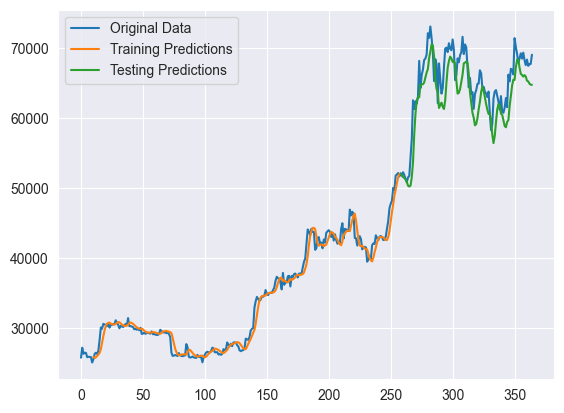

In [10]:
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(look_back, look_back + len(train_predict)), train_predict,
         label='Training Predictions')
plt.plot(
    np.arange(look_back + len(train_predict), len(train_predict) + len(test_predict) + look_back),
    test_predict, label='Testing Predictions')
plt.legend()
plt.show()